In [52]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [34]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [3]:
january = pd.read_parquet("data/green_tripdata_2021-01.parquet")
february= pd.read_parquet("data/green_tripdata_2021-02.parquet")


In [4]:
january.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[ns]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [5]:
january['lpep_dropoff_datetime'] = pd.to_datetime(january['lpep_dropoff_datetime'])
january['lpep_pickup_datetime'] = pd.to_datetime(january['lpep_pickup_datetime'])


In [6]:
january['duration'] = january.lpep_dropoff_datetime - january.lpep_pickup_datetime
january['duration'] = january['duration'].apply(lambda td: td.total_seconds() / 60)

january = january[(january['duration'] >=1) & (january['duration']<=60)]

categorial = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
january[categorial]= january[categorial].astype(str)

In [7]:
january['duration'].describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [8]:
january['duration'].describe(percentiles= [0.95,0.98,0.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

In [9]:
january.shape

(73908, 21)

In [10]:
january = january[(january['duration'] >=1) & (january['duration']<=60)]

In [11]:
january.shape

(73908, 21)

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
        df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])        
        
    elif filename.endswith('.parquet'):  
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)

    df = df[(df['duration'] >=1) & (df['duration']<=60)]

    categorical = ['PULocationID','DOLocationID']
    df[categorical]= df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe("data/green_tripdata_2021-01.parquet")
df_val= read_dataframe("data/green_tripdata_2021-02.parquet")

In [14]:
len(df_train), len(df_val)

(73908, 61921)

In [43]:
df_train['PU_DO'] = df_train['PULocationID'] + "_" + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + "_" + df_val['DOLocationID']

In [44]:
categorial = ['PU_DO'] #['PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorial + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorial + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)


In [45]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

### LinearRegression

In [46]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_val)

mean_squared_error(y_val,y_pred, squared= False)

7.4793657829373155

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


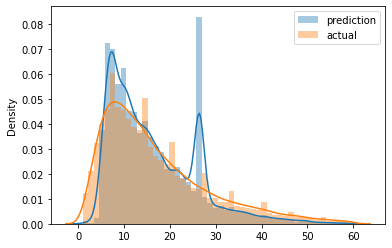

In [47]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

### Lasso

In [48]:
lasso = Lasso(alpha=0.001)

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_val)

mean_squared_error(y_val,y_pred, squared= False)

9.233436225720547

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


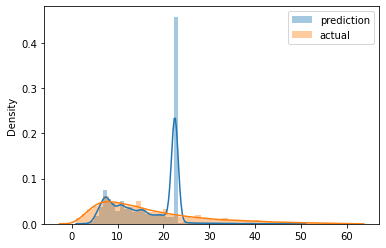

In [49]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

### Ridge

In [50]:
lasso = Ridge()

lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_val)

mean_squared_error(y_val,y_pred, squared= False)

11.342603943214286

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


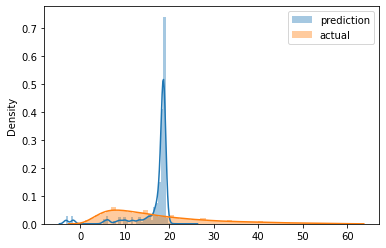

In [51]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()

### Save model

In [55]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,linear_reg), f_out)